# **Introduction to LangGraph**

In [1]:
from IPython.display import display, Markdown, Image
from dotenv import load_dotenv
load_dotenv()

True

On a high level, there are 3 steps before creating a graph - 
- Setting up the agent state
- Creating / having a set of tools for the agent to use
- Setup the agent and begin creating the graph

For creating the graph - 
- create the graph workflow by adding nodes and edges
- see if there is any need for conditional edges
- use functions properly to define the flow of the graph (like, is it an action, is it a call, is it the end, etc.)

**But we can start by building very simple graphs, without having complex states, conditional edges, tools, etc. as well**

So, let's begin!

In [2]:
from typing import TypedDict, Annotated
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

model = ChatOpenAI(model="gpt-4o-mini")

# let's create the agent state
class AgentState(TypedDict):
    messages: Annotated[list, add_messages] # adds messages to the state without overrides, maintaining state

In [3]:
# Our first graph
graph_builder = StateGraph(AgentState)

# a simple chatbot function for our graph
def chatbot(state: AgentState):
    return {
        "messages": model.invoke(state['messages']) # run model on all messages (simple history kinda)
    }

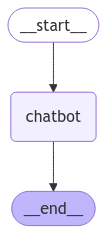

In [4]:
# let's add nodes and edges (obviously)
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_edge(START,"chatbot")
graph_builder.add_edge("chatbot",END)

graph = graph_builder.compile()

try: display(Image(graph.get_graph().draw_mermaid_png()))
except: pass

In [5]:
# Let's use our chatbot now
while True:
    query = input()
    print(f"You: {query}")
    if query.lower() in ("quit","exit"): break
    
    response = graph.invoke({"messages":[query]})
    print(f"AI: {response["messages"][-1].content}")

You: hey
AI: Hello! How can I assist you today?
You: what is 2+3?
AI: 2 + 3 equals 5.
You: quit


### Using tools
Now that we know how to create a graph simply, let's try adding tools.
The AI must use these tools to generate the response, if it is available. If not, then allowing it to generate its own response or to say that it can't answer, is up to you.

In [6]:
# import tools and utilities
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun

wikipedia_tool = WikipediaQueryRun(
    api_wrapper=WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
)

# you can also use tools directly, as they too (just like any other langchain class) have the invoke() method
print(wikipedia_tool.invoke("Who is Sachin Tendulkar?"))

Page: Sachin Tendulkar
Summary: Sachin Ramesh Tendulkar ( ; pronounced [sətɕin teːɳɖulkəɾ]; born 24 April 1973) is an Indian former international cricketer who captained the Indian national team. He is widely regarded as one of the greatest cricketers of all time, and is the holder of several world 


In [7]:
tools = [wikipedia_tool]

# we can create another state if we want, but let's use the same state class
graph_with_tools_builder = StateGraph(AgentState)

model_with_tools = model.bind_tools(tools=tools)

# update chatbot function
def chatbot(state: AgentState):
    return {
        "messages": model_with_tools.invoke(state['messages']) # use 'model_with_tools'
    }

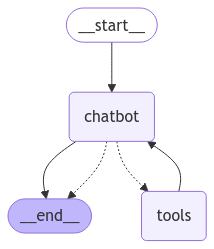

In [8]:
from langgraph.prebuilt import ToolNode, tools_condition # the tool is also has to be a node, so we hv2 make it as one

graph_with_tools_builder.add_node("chatbot",chatbot)
graph_with_tools_builder.add_edge(START,"chatbot")

tool_node = ToolNode(tools=tools)
graph_with_tools_builder.add_node("tools",tool_node)
graph_with_tools_builder.add_conditional_edges(
    "chatbot", tools_condition
)
graph_with_tools_builder.add_edge("tools","chatbot")

graph_with_tools_builder.add_edge("chatbot",END)

graph = graph_with_tools_builder.compile()

try: display(Image(graph.get_graph().draw_mermaid_png()))
except: pass

*As you can see, the dotted lines are conditional edges*

In [9]:
# Let's use our chatbot now
while True:
    query = input()
    print(f"You: {query}")
    if query.lower() in ("quit","exit"): break
    
    response = graph.invoke({"messages":[query]})
    response["messages"][-1].pretty_print()


You: tell me about sachin tendulkar
================================== Ai Message ==================================

Sachin Ramesh Tendulkar, born on April 24, 1973, is a former Indian international cricketer who captained the Indian national team. He is widely regarded as one of the greatest cricketers of all time and holds several world records in the sport. Tendulkar's cricketing career spanned over two decades, during which he became known for his exceptional batting skills and consistency.

He played a pivotal role in Indian cricket and is celebrated not only for his achievements on the field but also for his sportsmanship and humility. Tendulkar's contributions to cricket have made him an iconic figure in the sport, and he continues to inspire many aspiring cricketers around the world.
You: quit


### Creating Multi-agentic frameworks

**Building a RAG Application**

Let's see how to create multiple agents, connect them to tools and vector db anol.

In [26]:
import os
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

# Now let's see why adding metadata to RAG is important

data_folder = r"data"
persist_directory = r"db/chroma_db_with_metadata"

# No need to create if already exists
if not os.path.exists(persist_directory):
    print("--- Initializing Vector Store ---")
    
    files = [f for f in os.listdir(data_folder) if f.endswith(".txt")]
    documents = []

    for file in files:
        file_path = os.path.join(data_folder,file)
        loader = TextLoader(file_path)
        text_docs = loader.load()
        for doc in text_docs:
            doc.metadata = {"Source":file} # add metadata for the document
            documents.append(doc)

    text_splitter = CharacterTextSplitter(chunk_size=500,chunk_overlap=50)
    docs = text_splitter.split_documents(documents)

    print(f"Number of chunks: {len(docs)}")

    # create embeddings, initialize the vector store
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
    db = Chroma.from_documents(docs, embeddings, persist_directory=persist_directory)

    print("Embeddings ready, vector store initialized.")
else: print("Vector store already exists.")

db = Chroma(persist_directory=persist_directory,embedding_function=embeddings)

retriever = db.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={"k":1,"score_threshold":0.1}
)

# test retriever once
retriever.invoke("what are vertebrates?")

Vector store already exists.


[Document(metadata={'Source': 'animals.txt'}, page_content='## Classification of Animals  \nAnimals are broadly classified into **vertebrates** and **invertebrates** based on the presence or absence of a backbone.  \n\n### 1. Vertebrates  \nVertebrates are animals that have a backbone and a well-developed internal skeleton. They are further divided into five major classes:')]

In [16]:
# we can't use the same state now, and we need to create some schema... lot of work to do
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

# class for agent to route query (vector db or wiki search)
class RouteQuery(BaseModel):
    datasource : Literal["vectorstore","wikisearch"] = Field(
        ..., # means it can be anything, but has to be there
        description="Given user input, choose to route it to Wikipedia or vector database."
    )

In [18]:
# creating our router functions
structured_router = model.with_structured_output(RouteQuery) # this router decides from llm input

structured_router_prompt = """
You are an expert at routing a user query to vector database or wikipedia search.
The vector db contains information about animals, birds, music and food.
Use the vectorstore for these queries, and use wikisearch otherwise.
Don't answer the question, just provide the value for 'datasource'.
"""

prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system",structured_router_prompt),
        ("human","{query}")
    ]
)

router = prompt_template | structured_router 

# test the router
print(router.invoke({"query":"Tell me about animals in one line."}))
print(router.invoke({"query":"Who is Sachin Tendulkar?"}))

datasource='vectorstore'
datasource='wikisearch'


In [19]:
from typing import List

class GraphState(TypedDict):
    query: str # user query
    generation: str # LLM response
    documents: List[str] # list of docs


In [32]:
from langchain.schema import Document

# retrieval function for vectorstore agent
def retrieve(state: GraphState):
    """Retrieve documents from vectorstore and add it to the 'documents' of state"""
    questions = state['query']
    docs = retriever.invoke(questions)
    return {"documents": docs, "query": questions}

# search function for wikisearch agent
def search(state: GraphState):
    """Retrieve documents from wikipedia search and add it to the 'documents' of state"""
    questions = state['query']
    docs = Document(page_content=wikipedia_tool.invoke(questions))
    return {"documents": docs, "query": questions}

# router function
def route(state: GraphState):
    source = router.invoke({"query": state["query"]})
    return source.datasource

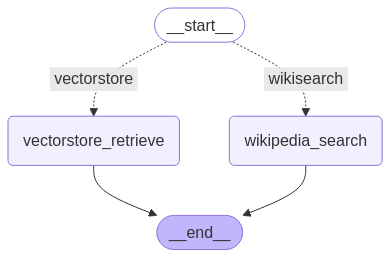

In [33]:
# Let's create our graph now! 

workflow = StateGraph(GraphState) # lol i dint think of this

workflow.add_node("wikipedia_search", search)
workflow.add_node("vectorstore_retrieve", retrieve)

workflow.add_conditional_edges(
    START,
    route,
    {
        "vectorstore": "vectorstore_retrieve",
        "wikisearch":"wikipedia_search"
    }
)

workflow.add_edge("vectorstore_retrieve",END)
workflow.add_edge("wikipedia_search",END)

graph = workflow.compile()

try: display(Image(graph.get_graph().draw_mermaid_png()))
except: pass

In [ ]:
# test our graph (not gonna make convos again...)
from pprint import pprint

inputs = [
    {
        "query": "Who is Sachin Tendulkar?"
    },
    {
        "query": "Tell me about animals and their classes"
    }
]

for user_input in inputs:
    print(user_input)
    for output in graph.stream(user_input):
        for k, v in output.items():
            pprint(f"Node: {k}: ")
            if k=="wikipedia_search": v["documents"]=[v["documents"]] # to make printing easy
            # wikipedia gives a document object, while vector retrieval gives a list of document objects

    pprint(v["documents"][0].page_content)
    print("----------")


{'query': 'Who is Sachin Tendulkar?'}
'Node: wikipedia_search: '
('Page: Sachin Tendulkar\n'
 'Summary: Sachin Ramesh Tendulkar ( ; pronounced [sətɕin teːɳɖulkəɾ]; born 24 '
 'April 1973) is an Indian former international cricketer who captained the '
 'Indian national team. He is widely regarded as one of the greatest '
 'cricketers of all time, and is the holder of several world ')
----------
{'query': 'Tell me about animals and their classes'}
'Node: vectorstore_retrieve: '
('## Classification of Animals  \n'
 'Animals are broadly classified into **vertebrates** and **invertebrates** '
 'based on the presence or absence of a backbone.  \n'
 '\n'
 '### 1. Vertebrates  \n'
 'Vertebrates are animals that have a backbone and a well-developed internal '
 'skeleton. They are further divided into five major classes:')
----------
